<div style="padding:18px;background-color:#03045e;border-radius:12px;text-align:center;color:white;font-family:'Rajdhani',-apple-system,BlinkMacSystemFont,'Segoe UI','Roboto','Helvetica Neue',Arial,sans-serif;">
<div style="font-size:36px;font-weight:700;">PRIVACY AUDIT</div>
<div style="font-size:16px;font-weight:500;opacity:0.75;">Adversarial Stress Analysis | Part : 2</div>
</div>

# <div style="padding:18px;background-color:#03045e;border-radius:12px;text-align:center;color:white;font-family:'Rajdhani',-apple-system,BlinkMacSystemFont,'Segoe UI','Roboto','Helvetica Neue',Arial,sans-serif;font-size:36px;font-weight:700;">Setup and Initialization</div>

<div style="background-color:#caf0f8;padding:18px;font-size:14px;font-weight:500;color:#001d3d;border-radius:12px;line-height:1.5;">

## **Loading Baseline Models and Data**
Similar to the integrity audit notebook, this privacy audit notebook requires loading all necessary components from the baseline notebook outputs or input dataset. The setup process includes:

* **Loading raw data:** Training and test images (`X_train`, `X_test`), labels (`y_train`, `y_test`), and tabular features from previous experiments
* **Loading trained models:** Pre-trained `dual_image_client`, `dual_tabular_client`, and `transformer_server` models
* **Loading or computing embeddings:** Feature embeddings (`test_spec_img`, `test_inv_img`, `test_spec_tab`, `test_inv_tab` and corresponding training set variables) for both training and test sets (cached when available)
* **Computing baseline metrics:** Establishing baseline performance metrics (`vfl4_test_acc`, `vfl4_balanced_acc`, `per_class_acc`) for comparison with attack results

This setup ensures that all privacy attacks can be evaluated against a consistent baseline model and data configuration.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model, clone_model
from tensorflow.keras.layers import (Input, Concatenate, Dense, Dropout, 
                                     LayerNormalization, MultiHeadAttention, 
                                     Reshape, Flatten)
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, accuracy_score
import seaborn as sns
import pickle
import warnings
import os
from IPython.display import HTML, display

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
warnings.filterwarnings('ignore')

ENABLE_CACHING = True
INPUT_DATASET_DIR = '/kaggle/input/hybridvfl-exp-4/'
WORKING_DIR = '/kaggle/working/'
CACHE_DIR = '/kaggle/working/cache/'
BASE_PATH_EXP1 = '/kaggle/input/hybridvfl-exp-1/'
BASE_PATH_EXP2 = '/kaggle/input/hybridvfl-exp-2/'

ASSET_NAMES = {
    'dual_image_client': 'exp4_dual_image_client.keras',
    'dual_tabular_client': 'exp4_dual_tabular_client.keras',
    'transformer_server': 'exp4_transformer_server.keras',
    'train_embeddings': 'cache/train_embeddings.npz',
    'test_embeddings': 'cache/test_embeddings.npz',
}

os.makedirs(CACHE_DIR, exist_ok=True)

def find_asset(asset_name):
    input_path = INPUT_DATASET_DIR + ASSET_NAMES[asset_name]
    if os.path.isfile(input_path):
        return input_path
    if asset_name in ['train_embeddings', 'test_embeddings']:
        working_path = CACHE_DIR + ASSET_NAMES[asset_name].replace('cache/', '')
    else:
        working_path = WORKING_DIR + ASSET_NAMES[asset_name]
    if os.path.isfile(working_path):
        return working_path
    return None

def embeddings_cached():
    return (find_asset('test_embeddings') is not None and
            find_asset('train_embeddings') is not None)

X_train = np.load(BASE_PATH_EXP1 + 'X_train.npy')
X_test = np.load(BASE_PATH_EXP1 + 'X_test.npy')
y_train = np.load(BASE_PATH_EXP1 + 'y_train.npy')
y_test = np.load(BASE_PATH_EXP1 + 'y_test.npy')
train_tabular_features = np.load(BASE_PATH_EXP2 + 'train_tabular_features.npy')
test_tabular_features = np.load(BASE_PATH_EXP2 + 'test_tabular_features.npy')

with open(BASE_PATH_EXP1 + 'class_weight_dict.pkl', 'rb') as f:
    class_weight_dict = pickle.load(f)

img_path = find_asset('dual_image_client')
tab_path = find_asset('dual_tabular_client')
server_path = find_asset('transformer_server')

if not (img_path and tab_path and server_path):
    raise FileNotFoundError("Required models not found. Please ensure baseline notebook has been run and models are saved.")

dual_image_client = load_model(img_path)
dual_tabular_client = load_model(tab_path)
transformer_server = load_model(server_path)

if ENABLE_CACHING and embeddings_cached():
    test_emb_path = find_asset('test_embeddings')
    train_emb_path = find_asset('train_embeddings')
    test_embeddings = np.load(test_emb_path)
    test_spec_img = test_embeddings['spec_img']
    test_inv_img = test_embeddings['inv_img']
    test_spec_tab = test_embeddings['spec_tab']
    test_inv_tab = test_embeddings['inv_tab']
    train_embeddings = np.load(train_emb_path)
    train_spec_img = train_embeddings['spec_img']
    train_inv_img = train_embeddings['inv_img']
    train_spec_tab = train_embeddings['spec_tab']
    train_inv_tab = train_embeddings['inv_tab']
else:
    test_spec_img, test_inv_img = dual_image_client.predict(X_test, verbose=0)
    test_spec_tab, test_inv_tab = dual_tabular_client.predict(test_tabular_features, verbose=0)
    train_spec_img, train_inv_img = dual_image_client.predict(X_train, verbose=0)
    train_spec_tab, train_inv_tab = dual_tabular_client.predict(train_tabular_features, verbose=0)

test_predictions = transformer_server.predict([test_spec_img, test_inv_img, test_spec_tab, test_inv_tab], verbose=0)
y_pred = np.argmax(test_predictions, axis=1)
y_true = np.argmax(y_test, axis=1)
vfl4_test_acc = accuracy_score(y_true, y_pred)
vfl4_balanced_acc = balanced_accuracy_score(y_true, y_pred)
lesion_types = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

print(f"Setup complete: Baseline accuracy = {vfl4_test_acc:.4f}, Balanced accuracy = {vfl4_balanced_acc:.4f}")

2025-12-24 15:38:04.860175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766590685.048838      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766590685.101933      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766590685.537022      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766590685.537066      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766590685.537068      23 computation_placer.cc:177] computation placer alr

Setup complete: Baseline accuracy = 0.8925, Balanced accuracy = 0.9285


# <div style="padding:18px;background-color:#03045e;border-radius:12px;text-align:center;color:white;font-family:'Rajdhani',-apple-system,BlinkMacSystemFont,'Segoe UI','Roboto','Helvetica Neue',Arial,sans-serif;font-size:36px;font-weight:700;">Privacy Attacks</div>

<div style="background-color:#caf0f8;padding:18px;font-size:14px;font-weight:500;color:#001d3d;border-radius:12px;line-height:1.5;">

## **Label Inference Attack**
This attack models an eavesdropping adversary who captures gradients during the federated learning process to infer private labels without accessing raw data. In real-world scenarios, this could occur if a malicious server operator intercepts gradient updates or if gradient information leaks through side channels. In a medical context, this corresponds to inferring patient diagnoses from gradient information.

The attack extracts gradients with respect to image-invariant embeddings (`inv_img`) during the forward-backward pass through the transformer server. These gradients contain information about how the model would adjust its parameters based on the sample's label, effectively leaking label information. A Random Forest classifier is then trained to infer labels directly from these gradient vectors.

We assess attack effectiveness using t-SNE visualization, where well-separated clusters indicate high inference success and severe privacy leakage, while overlapping clusters suggest limited attack capability.

**Attack Configuration:**
* **Attack Method:** Gradient-based Label Inference
* **Target:** Image-invariant embeddings (`inv_img`)
* **Gradient Dimension:** 256
* **Total Samples:** Full test set

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

ATTACK_SAMPLE_SIZE = len(y_test)

test_inv_img_for_attack = test_inv_img.copy()
test_spec_img_for_attack = test_spec_img.copy()
test_inv_tab_for_attack = test_inv_tab.copy()
test_spec_tab_for_attack = test_spec_tab.copy()
y_test_labels = np.argmax(y_test, axis=1)

captured_gradients = []

for i in range(ATTACK_SAMPLE_SIZE):
    sample_spec_img = test_spec_img_for_attack[i:i+1]
    sample_inv_img = test_inv_img_for_attack[i:i+1]
    sample_spec_tab = test_spec_tab_for_attack[i:i+1]
    sample_inv_tab = test_inv_tab_for_attack[i:i+1]
    sample_label = y_test[i:i+1]
    
    sample_spec_img_tensor = tf.constant(sample_spec_img, dtype=tf.float32)
    sample_inv_img_tensor = tf.Variable(sample_inv_img, dtype=tf.float32)
    sample_spec_tab_tensor = tf.constant(sample_spec_tab, dtype=tf.float32)
    sample_inv_tab_tensor = tf.constant(sample_inv_tab, dtype=tf.float32)
    sample_label_tensor = tf.constant(sample_label, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        predictions = transformer_server([
            sample_spec_img_tensor, 
            sample_inv_img_tensor, 
            sample_spec_tab_tensor, 
            sample_inv_tab_tensor
        ], training=False)
        
        loss = tf.keras.losses.categorical_crossentropy(sample_label_tensor, predictions)
    
    gradients = tape.gradient(loss, sample_inv_img_tensor)
    captured_gradients.append(gradients.numpy().flatten())
    
    if (i + 1) % 200 == 0:
        print(f"Processed {i+1}/{ATTACK_SAMPLE_SIZE} samples")

captured_gradients = np.array(captured_gradients)

X_attack = captured_gradients
y_attack = y_test_labels

X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
    X_attack, y_attack, test_size=0.3, random_state=RANDOM_STATE, stratify=y_attack
)

attack_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
attack_model.fit(X_train_attack, y_train_attack)

y_pred_attack = attack_model.predict(X_test_attack)
attack_accuracy = accuracy_score(y_test_attack, y_pred_attack)
attack_balanced_acc = balanced_accuracy_score(y_test_attack, y_pred_attack)

random_baseline = 1.0 / 7
lia_results = {
    'attack_accuracy': attack_accuracy,
    'attack_balanced_acc': attack_balanced_acc,
    'random_baseline': random_baseline,
    'privacy_leakage': attack_accuracy - random_baseline,
    'gradient_shape': captured_gradients.shape,
    'attack_samples': len(X_attack)
}

if attack_accuracy > 0.8:
    privacy_status = "CRITICAL BREACH"
elif attack_accuracy > 0.6:
    privacy_status = "MODERATE LEAKAGE"
elif attack_accuracy > 0.3:
    privacy_status = "MINOR LEAKAGE"
else:
    privacy_status = "SECURE"
attack_perf_data = [
    {
        "Metric": "Attack Accuracy",
        "Value": f"{attack_accuracy:.4f}"
    },
    {
        "Metric": "Attack Balanced Accuracy",
        "Value": f"{attack_balanced_acc:.4f}"
    },
    {
        "Metric": "Random Baseline",
        "Value": f"{random_baseline:.4f}"
    },
    {
        "Metric": "Privacy Leakage",
        "Value": f"{lia_results['privacy_leakage']:.4f}"
    },
    {
        "Metric": "Privacy Status",
        "Value": privacy_status
    }
]
df_attack_perf = pd.DataFrame(attack_perf_data)
html_attack_perf = df_attack_perf.to_html(index=False, classes='table table-striped table-bordered', table_id='attack_model_performance')
display(HTML("<h4>Attack Model Performance</h4>" + html_attack_perf))

Processed 200/5313 samples
Processed 400/5313 samples
Processed 600/5313 samples
Processed 800/5313 samples
Processed 1000/5313 samples
Processed 1200/5313 samples
Processed 1400/5313 samples
Processed 1600/5313 samples
Processed 1800/5313 samples
Processed 2000/5313 samples
Processed 2200/5313 samples
Processed 2400/5313 samples
Processed 2600/5313 samples
Processed 2800/5313 samples
Processed 3000/5313 samples
Processed 3200/5313 samples
Processed 3400/5313 samples
Processed 3600/5313 samples
Processed 3800/5313 samples
Processed 4000/5313 samples
Processed 4200/5313 samples
Processed 4400/5313 samples
Processed 4600/5313 samples
Processed 4800/5313 samples
Processed 5000/5313 samples
Processed 5200/5313 samples


Metric,Value
Attack Accuracy,0.9937
Attack Balanced Accuracy,0.9821
Random Baseline,0.1429
Privacy Leakage,0.8509
Privacy Status,CRITICAL BREACH


Computing t-SNE projection of gradients


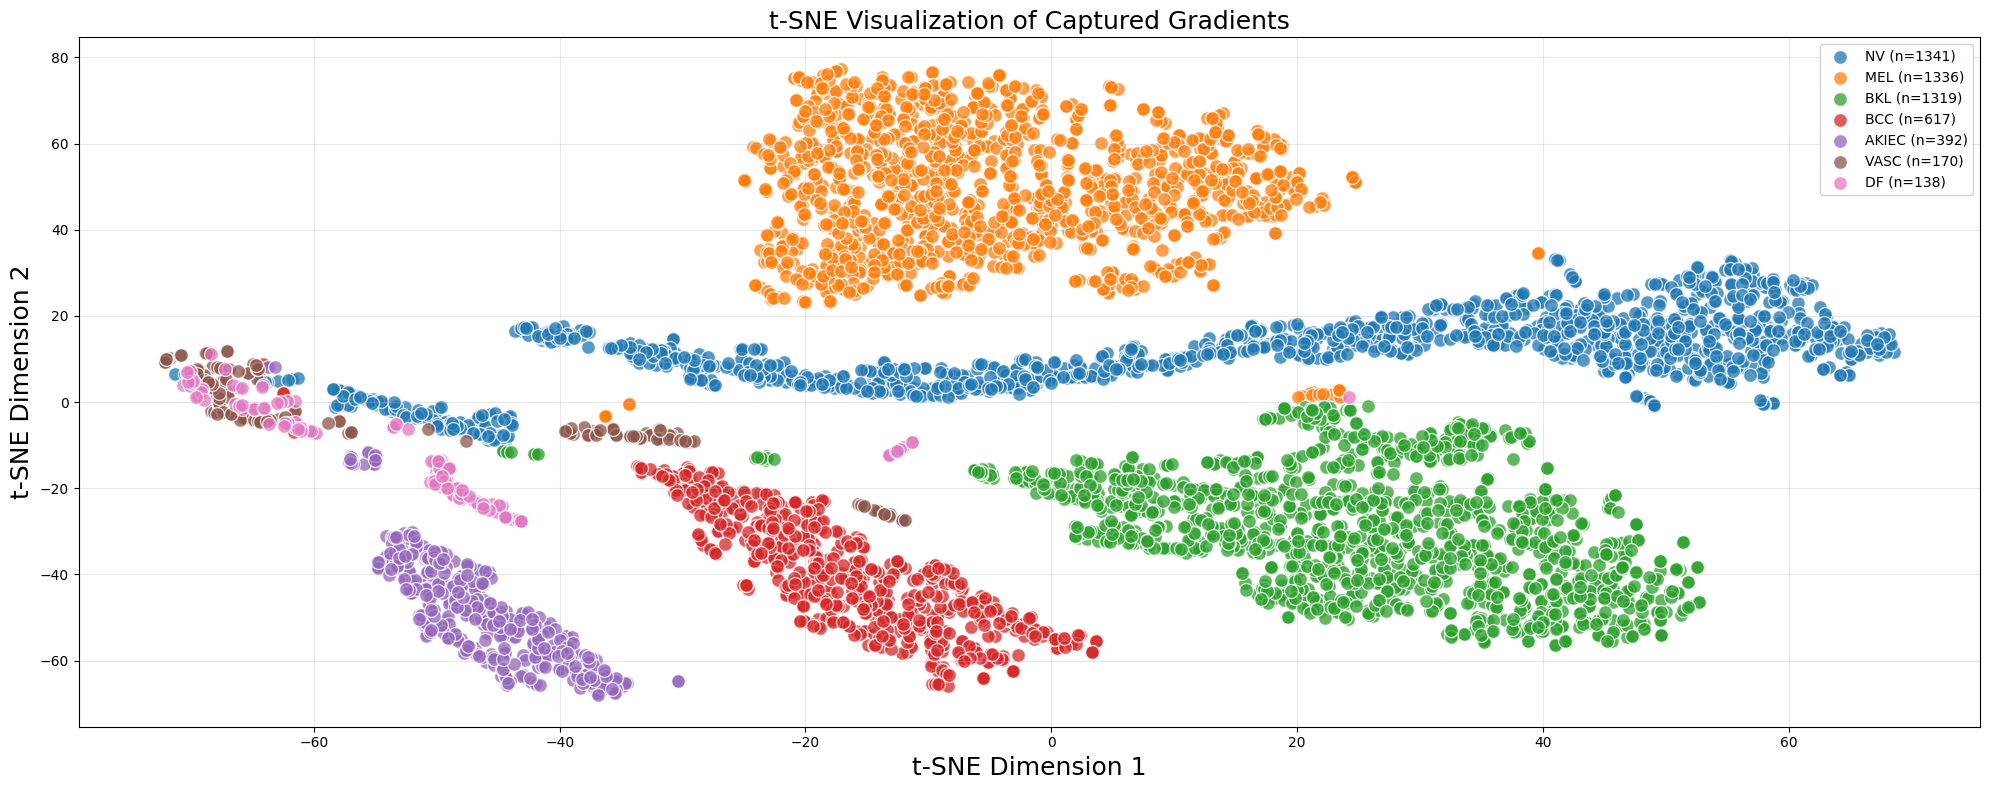

Metric,Value,Interpretation
Attack Accuracy,0.9937,CRITICAL BREACH
Attack Balanced Accuracy,0.9821,-
Random Baseline (1/7 classes),0.1429,No leakage
Privacy Leakage,0.8509,85.1% above random


In [3]:
# Visualization: Label Inference Attack - t-SNE of Gradients

print("Computing t-SNE projection of gradients")

# Apply t-SNE to reduce gradient dimensionality for visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=RANDOM_STATE, verbose=0)
gradients_2d = tsne.fit_transform(captured_gradients)

fig, ax = plt.subplots(figsize=(20, 8))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for i, lesion in enumerate(lesion_types):
    mask = y_test_labels == i
    ax.scatter(
        gradients_2d[mask, 0], 
        gradients_2d[mask, 1],
        c=colors[i],
        label=f'{lesion.upper()} (n={np.sum(mask)})',
        s=100,
        alpha=0.75,
        edgecolor='white',
        linewidth=1.0
    )

ax.set_xlabel('t-SNE Dimension 1', fontsize=18, fontweight='normal')
ax.set_ylabel('t-SNE Dimension 2', fontsize=18, fontweight='normal')
ax.set_title(f't-SNE Visualization of Captured Gradients', 
             fontsize=18, fontweight='normal')
ax.legend(loc='best', fontsize=10, framealpha=0.9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

privacy_leakage_pct = lia_results['privacy_leakage'] * 100
leakage_interpretation = f"{privacy_leakage_pct:.1f}% above random"

lia_results_data = [
    {
        "Metric": "Attack Accuracy",
        "Value": f"{attack_accuracy:.4f}",
        "Interpretation": privacy_status
    },
    {
        "Metric": "Attack Balanced Accuracy",
        "Value": f"{attack_balanced_acc:.4f}",
        "Interpretation": "-"
    },
    {
        "Metric": "Random Baseline (1/7 classes)",
        "Value": f"{random_baseline:.4f}",
        "Interpretation": "No leakage"
    },
    {
        "Metric": "Privacy Leakage",
        "Value": f"{lia_results['privacy_leakage']:.4f}",
        "Interpretation": leakage_interpretation
    }
]
df_lia_results = pd.DataFrame(lia_results_data)
html_lia_results = df_lia_results.to_html(index=False, classes='table table-striped table-bordered', table_id='lia_results_summary')
display(HTML("<h4>Results Summary</h4>" + html_lia_results))

<div style="background-color:#caf0f8;padding:18px;font-size:14px;font-weight:500;color:#001d3d;border-radius:12px;line-height:1.5;">

## **Membership Inference Attack**
This attack evaluates privacy leakage by testing whether an adversary at the central server can determine if a patient sample was part of the training set (member) or not (non-member), without accessing raw images or tabular records. In real-world scenarios, this corresponds to a malicious server operator or compromised central infrastructure attempting to identify which patients were included in the training dataset.

**Threat Model:**

* The server has access to stored multimodal embeddings (`spec_img`, `inv_img`, `spec_tab`, `inv_tab`)
* The server can query `transformer_server` to obtain prediction probabilities
* The server also has access to `y_true` labels (as in many real clinical pipelines)
* Raw patient data remains inaccessible

**Attack Strategy:**

We build multiple attacker designs to estimate membership using signals derived from the model's behavior:

* **Baseline attacker:** Uses `confidence`, `entropy`, and `predicted_label` as features
* **Enhanced attacker:** Uses full softmax probability vector plus membership-sensitive signals such as `loss`, `correctness`, `margin`, and `top-2 probability`
* **Nonlinear attacker:** Uses a stronger classifier (gradient boosting/XGBoost) to capture complex patterns
* **Per-class attacker:** Separate attackers per lesion type to study whether vulnerability differs across clinical categories

**Evaluation Protocol:**

Attack models are assessed under repeated stratified cross-validation with multiple random seeds, using standard privacy-auditing metrics such as AUC and TPR at low FPR to quantify membership distinguishability under strict false-alarm constraints.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from scipy.stats import entropy as scipy_entropy
import warnings
warnings.filterwarnings('ignore')

# Try to import XGBoost (may not be available)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except:
    XGBOOST_AVAILABLE = False

train_predictions = transformer_server.predict(
    [train_spec_img, train_inv_img, train_spec_tab, train_inv_tab],
    verbose=0
)
y_train_classes = np.argmax(y_train, axis=1)

test_predictions = transformer_server.predict(
    [test_spec_img, test_inv_img, test_spec_tab, test_inv_tab],
    verbose=0
)
y_test_classes = np.argmax(y_test, axis=1)

def extract_rich_features(predictions, y_true_classes):
    """
    Extract rich feature set for membership inference.
    Features: full softmax (7) + confidence + entropy + margin + top2_prob + loss + correctness
    """
    features_list = []
    
    for i in range(len(predictions)):
        pred = predictions[i]
        true_class = y_true_classes[i]
        
        sorted_probs = np.sort(pred)[::-1]
        
        confidence = sorted_probs[0]
        entropy = scipy_entropy(pred)
        margin = sorted_probs[0] - sorted_probs[1]
        top2_prob = sorted_probs[1]
        
        # Loss (cross-entropy with true label)
        true_prob = pred[true_class]
        loss = -np.log(true_prob + 1e-10)
        
        # Correctness
        predicted_class = np.argmax(pred)
        correctness = 1.0 if predicted_class == true_class else 0.0
        
        # Combine: full softmax (7) + additional features (6)
        feature_vector = np.concatenate([
            pred,  # 7 dims
            [confidence, entropy, margin, top2_prob, loss, correctness]  # 6 dims
        ])
        features_list.append(feature_vector)
    
    return np.array(features_list)

train_features = extract_rich_features(train_predictions, y_train_classes)
test_features = extract_rich_features(test_predictions, y_test_classes)
X_attack = np.vstack([train_features, test_features])
y_attack = np.concatenate([np.ones(len(train_features)), np.zeros(len(test_features))])
class_labels = np.concatenate([y_train_classes, y_test_classes])

print(f"\nAttack dataset: {len(X_attack)} samples")
print(f"  Members: {np.sum(y_attack == 1)} | Non-members: {np.sum(y_attack == 0)}")

# Phase 3: Attack Evaluation
print("\nPHASE 3: ATTACK EVALUATION (5-FOLD CV × 5 SEEDS)")

def evaluate_attack(X, y, model, n_splits=5, n_seeds=5):
    """Evaluate attack with stratified k-fold CV and multiple seeds."""
    auc_scores, acc_scores, prec_scores, rec_scores = [], [], [], []
    tpr1_scores, tpr5_scores = [], []
    
    for seed in range(n_seeds):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE + seed)
        
        for train_idx, test_idx in skf.split(X, y):
            X_tr, X_te = X[train_idx], X[test_idx]
            y_tr, y_te = y[train_idx], y[test_idx]
            
            model_clone = clone(model)
            model_clone.fit(X_tr, y_tr)
            
            y_pred_proba = model_clone.predict_proba(X_te)[:, 1]
            y_pred = (y_pred_proba > 0.5).astype(int)
            
            auc = roc_auc_score(y_te, y_pred_proba)
            acc = accuracy_score(y_te, y_pred)
            prec, rec, _, _ = precision_recall_fscore_support(y_te, y_pred, average='binary', zero_division=0)
            
            fpr, tpr, _ = roc_curve(y_te, y_pred_proba)
            idx1 = np.where(fpr <= 0.01)[0]
            idx5 = np.where(fpr <= 0.05)[0]
            tpr1 = tpr[idx1[-1]] if len(idx1) > 0 else 0.0
            tpr5 = tpr[idx5[-1]] if len(idx5) > 0 else 0.0
            
            auc_scores.append(auc)
            acc_scores.append(acc)
            prec_scores.append(prec)
            rec_scores.append(rec)
            tpr1_scores.append(tpr1)
            tpr5_scores.append(tpr5)
    
    return {
        'auc_mean': np.mean(auc_scores), 'auc_std': np.std(auc_scores),
        'acc_mean': np.mean(acc_scores), 'acc_std': np.std(acc_scores),
        'prec_mean': np.mean(prec_scores), 'prec_std': np.std(prec_scores),
        'rec_mean': np.mean(rec_scores), 'rec_std': np.std(rec_scores),
        'tpr1_mean': np.mean(tpr1_scores), 'tpr1_std': np.std(tpr1_scores),
        'tpr5_mean': np.mean(tpr5_scores), 'tpr5_std': np.std(tpr5_scores),
    }

train_conf = np.max(train_predictions, axis=1)
test_conf = np.max(test_predictions, axis=1)
train_ent = np.array([scipy_entropy(p) for p in train_predictions])
test_ent = np.array([scipy_entropy(p) for p in test_predictions])
train_pred = np.argmax(train_predictions, axis=1)
test_pred = np.argmax(test_predictions, axis=1)
X_baseline = np.vstack([
    np.column_stack([train_conf, train_ent, train_pred]),
    np.column_stack([test_conf, test_ent, test_pred])
])
model_baseline = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
results_baseline = evaluate_attack(X_baseline, y_attack, model_baseline)

model_enhanced = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
results_enhanced = evaluate_attack(X_attack, y_attack, model_enhanced)

if XGBOOST_AVAILABLE:
    model_nonlinear = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, 
                                        random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
else:
    model_nonlinear = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, 
                                                   random_state=RANDOM_STATE)
results_nonlinear = evaluate_attack(X_attack, y_attack, model_nonlinear)

per_class_results = []
for class_idx in range(7):
    class_mask = (class_labels == class_idx)
    X_class = X_attack[class_mask]
    y_class = y_attack[class_mask]
    
    if len(X_class) < 20 or len(np.unique(y_class)) < 2:
        continue
    
    model_class = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
    results_class = evaluate_attack(X_class, y_class, model_class, n_splits=3, n_seeds=3)
    per_class_results.append({
        'class': lesion_types[class_idx],
        'n_samples': len(X_class),
        'auc_mean': results_class['auc_mean'],
        'auc_std': results_class['auc_std'],
    })


Attack dataset: 26565 samples
  Members: 21252 | Non-members: 5313

PHASE 3: ATTACK EVALUATION (5-FOLD CV × 5 SEEDS)


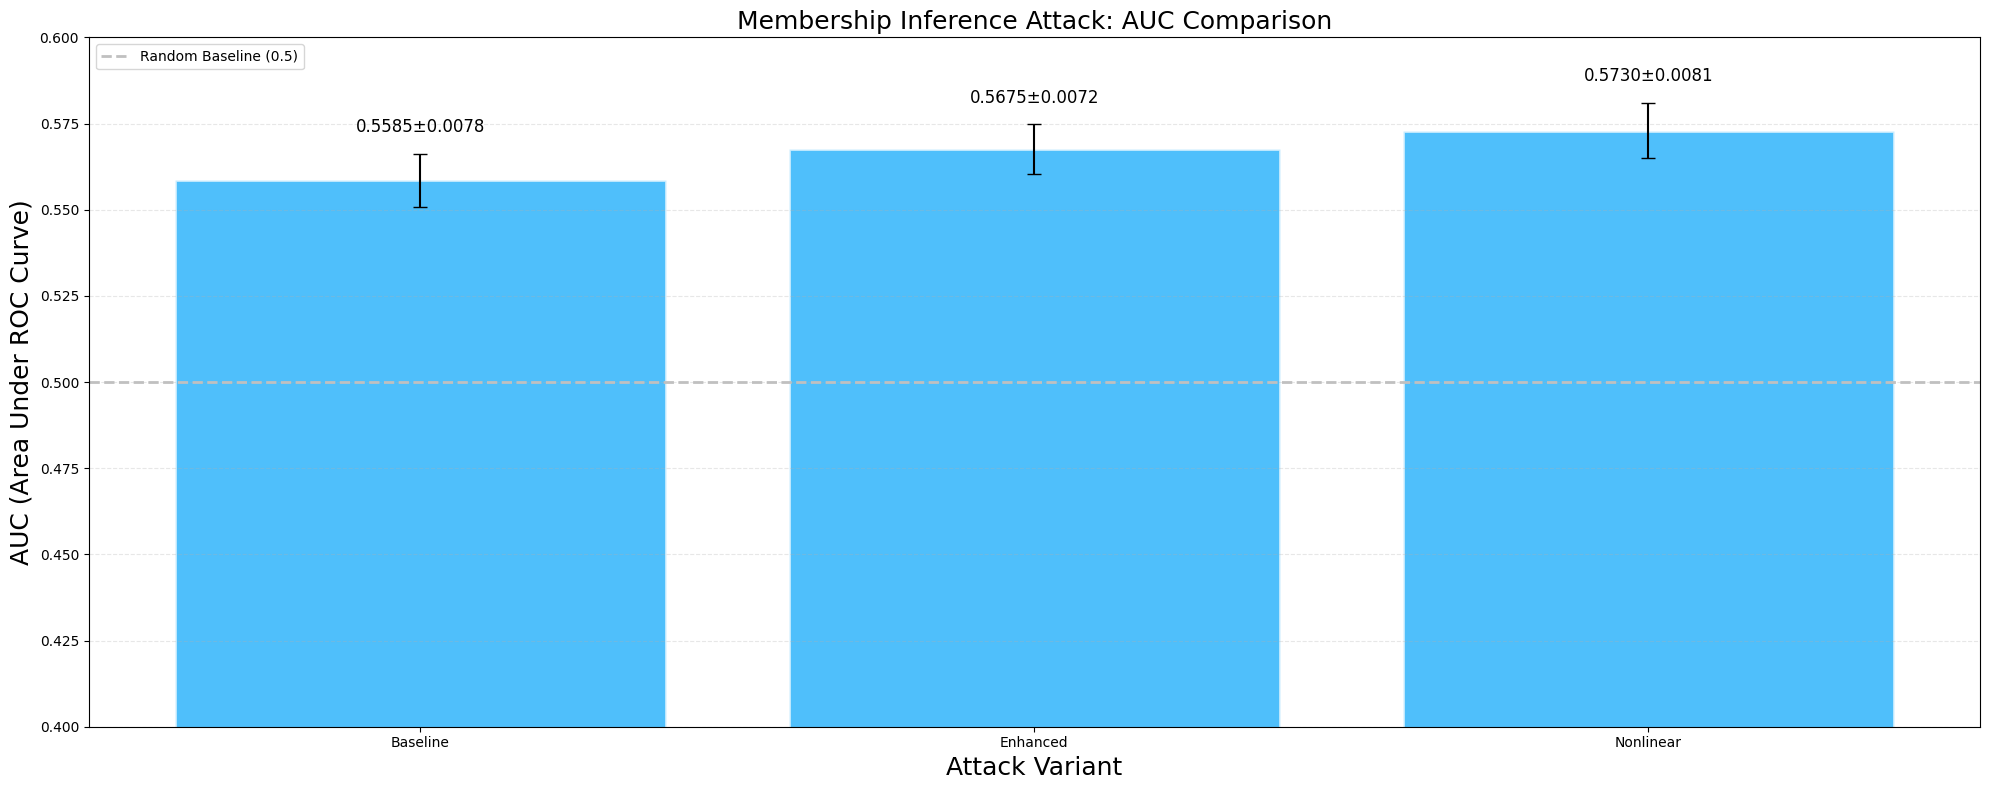

Attack,Model,AUC,Accuracy
Baseline,Logistic Regression,0.5585 ± 0.0078,0.8000 ± 0.0001
Enhanced,Logistic Regression,0.5675 ± 0.0072,0.8021 ± 0.0012
Nonlinear,XGBoost/GradientBoosting,0.5730 ± 0.0081,0.8042 ± 0.0016


Attack,Precision,Recall,TPR@1%FPR,TPR@5%FPR
Baseline,0.8000 ± 0.0001,1.0000 ± 0.0000,0.0106 ± 0.0032,0.0581 ± 0.0071
Enhanced,0.8033 ± 0.0008,0.9968 ± 0.0009,0.0127 ± 0.0044,0.0706 ± 0.0086
Nonlinear,0.8073 ± 0.0009,0.9920 ± 0.0015,0.0149 ± 0.0042,0.0644 ± 0.0071


Class,Samples,AUC
nv,6705,0.5428 ± 0.0134
mel,6678,0.5949 ± 0.0113
bkl,6594,0.5752 ± 0.0138
bcc,3084,0.5988 ± 0.0124
akiec,1962,0.6547 ± 0.0181
vasc,852,0.5333 ± 0.0367
df,690,0.5901 ± 0.0508


In [5]:
# Metrics from previous cell
attack_names = ['Baseline', 'Enhanced', 'Nonlinear']
auc_means = [
    results_baseline['auc_mean'],
    results_enhanced['auc_mean'],
    results_nonlinear['auc_mean']
]
auc_stds = [
    results_baseline['auc_std'],
    results_enhanced['auc_std'],
    results_nonlinear['auc_std']
]

fig, ax = plt.subplots(figsize=(20, 8))
x_pos = np.arange(len(attack_names))
bars = ax.bar(x_pos, auc_means, yerr=auc_stds, capsize=5, alpha=0.7,color='#04A5FA', edgecolor='white', linewidth=2)

# Add horizontal line at random baseline (0.5)
ax.axhline(y=0.5, color='#C0C0C0', linestyle='--', linewidth=2, label='Random Baseline (0.5)')

# Annotate bars with values
for i, (bar, mean, std) in enumerate(zip(bars, auc_means, auc_stds)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.005,
            f'{mean:.4f}±{std:.4f}', ha='center', va='bottom', fontsize=12, fontweight='normal')

ax.set_xlabel('Attack Variant', fontsize=18, fontweight='normal')
ax.set_ylabel('AUC (Area Under ROC Curve)', fontsize=18, fontweight='normal')
ax.set_title('Membership Inference Attack: AUC Comparison', fontsize=18, fontweight='normal')
ax.set_xticks(x_pos)
ax.set_xticklabels(attack_names)
ax.set_ylim([0.40, 0.60])
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

mia_perf_data = [
    {
        "Attack": "Baseline",
        "Model": "Logistic Regression",
        "AUC": f"{results_baseline['auc_mean']:.4f} ± {results_baseline['auc_std']:.4f}",
        "Accuracy": f"{results_baseline['acc_mean']:.4f} ± {results_baseline['acc_std']:.4f}"
    },
    {
        "Attack": "Enhanced",
        "Model": "Logistic Regression",
        "AUC": f"{results_enhanced['auc_mean']:.4f} ± {results_enhanced['auc_std']:.4f}",
        "Accuracy": f"{results_enhanced['acc_mean']:.4f} ± {results_enhanced['acc_std']:.4f}"
    },
    {
        "Attack": "Nonlinear",
        "Model": "XGBoost/GradientBoosting",
        "AUC": f"{results_nonlinear['auc_mean']:.4f} ± {results_nonlinear['auc_std']:.4f}",
        "Accuracy": f"{results_nonlinear['acc_mean']:.4f} ± {results_nonlinear['acc_std']:.4f}"
    }
]
df_mia_perf = pd.DataFrame(mia_perf_data)
html_mia_perf = df_mia_perf.to_html(index=False, classes='table table-striped table-bordered', table_id='mia_attack_performance')
display(HTML("<h4>Attack Performance</h4>" + html_mia_perf))

mia_detailed_data = [
    {
        "Attack": "Baseline",
        "Precision": f"{results_baseline['prec_mean']:.4f} ± {results_baseline['prec_std']:.4f}",
        "Recall": f"{results_baseline['rec_mean']:.4f} ± {results_baseline['rec_std']:.4f}",
        "TPR@1%FPR": f"{results_baseline['tpr1_mean']:.4f} ± {results_baseline['tpr1_std']:.4f}",
        "TPR@5%FPR": f"{results_baseline['tpr5_mean']:.4f} ± {results_baseline['tpr5_std']:.4f}"
    },
    {
        "Attack": "Enhanced",
        "Precision": f"{results_enhanced['prec_mean']:.4f} ± {results_enhanced['prec_std']:.4f}",
        "Recall": f"{results_enhanced['rec_mean']:.4f} ± {results_enhanced['rec_std']:.4f}",
        "TPR@1%FPR": f"{results_enhanced['tpr1_mean']:.4f} ± {results_enhanced['tpr1_std']:.4f}",
        "TPR@5%FPR": f"{results_enhanced['tpr5_mean']:.4f} ± {results_enhanced['tpr5_std']:.4f}"
    },
    {
        "Attack": "Nonlinear",
        "Precision": f"{results_nonlinear['prec_mean']:.4f} ± {results_nonlinear['prec_std']:.4f}",
        "Recall": f"{results_nonlinear['rec_mean']:.4f} ± {results_nonlinear['rec_std']:.4f}",
        "TPR@1%FPR": f"{results_nonlinear['tpr1_mean']:.4f} ± {results_nonlinear['tpr1_std']:.4f}",
        "TPR@5%FPR": f"{results_nonlinear['tpr5_mean']:.4f} ± {results_nonlinear['tpr5_std']:.4f}"
    }
]
df_mia_detailed = pd.DataFrame(mia_detailed_data)
html_mia_detailed = df_mia_detailed.to_html(index=False, classes='table table-striped table-bordered', table_id='mia_detailed_metrics')
display(HTML("<h4>Detailed Metrics</h4>" + html_mia_detailed))

if len(per_class_results) > 0:
    per_class_data = []
    for row in per_class_results:
        per_class_data.append({
            "Class": row['class'],
            "Samples": f"{row['n_samples']}",
            "AUC": f"{row['auc_mean']:.4f} ± {row['auc_std']:.4f}"
        })
    df_per_class = pd.DataFrame(per_class_data)
    html_per_class = df_per_class.to_html(index=False, classes='table table-striped table-bordered', table_id='per_class_membership_inference')
    display(HTML("<h4>Per-Class Membership Inference</h4>" + html_per_class))

<div style="background-color:#caf0f8;padding:18px;font-size:14px;font-weight:500;color:#001d3d;border-radius:12px;line-height:1.5;">

## **Data Reconstruction Attack**
These attacks examine whether feature embeddings shared in a Vertical Federated Learning (VFL) system can be reverse-engineered to recover sensitive patient information, even when raw data is never exchanged. In real-world scenarios, this corresponds to a malicious server operator attempting to reconstruct patient data from the embeddings they receive.

**Image Reconstruction (Model Inversion) Attack:**

A decoder is trained to map image-specific embeddings (`spec_img`) back to pixel space. The attacker only accesses embeddings stored at the server. Even when reconstructed images are blurry or incomplete, they can still reveal clinically sensitive details such as lesion location, shape, size, and skin tone. Under medical data regulations, such partial reconstructions already constitute a privacy breach, as they expose identifiable visual health information.

**Tabular Data Reconstruction (Attribute Inference) Attack:**

A decoder is trained to infer demographic attributes, specifically age category and binary gender, from tabular embeddings (`spec_tab`). The ability to recover these attributes without access to original records demonstrates that tabular representations preserve protected health information (PHI).

Taken together, these attacks demonstrate that:
* Image embeddings can reveal what the lesion looks like
* Tabular embeddings can reveal who the patient is

This combination shows that sharing "anonymized" embeddings alone does not ensure privacy in medical VFL systems and can lead to regulatory violations if not properly protected.

In [6]:
RECONSTRUCTION_EPOCHS = 20
RECONSTRUCTION_BATCH_SIZE = 32
RECONSTRUCTION_LEARNING_RATE = 0.001

In [7]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU

decoder_input = Input(shape=(train_spec_img.shape[1],), name='embedding_input')

x = Dense(7 * 7 * 256, activation='relu', name='dense_project')(decoder_input)
x = Reshape((7, 7, 256), name='reshape_3d')(x)

x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', name='upsample1')(x)
x = BatchNormalization(name='bn1')(x)
x = LeakyReLU(alpha=0.2, name='lrelu1')(x)

x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', name='upsample2')(x)
x = BatchNormalization(name='bn2')(x)
x = LeakyReLU(alpha=0.2, name='lrelu2')(x)

x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', name='upsample3')(x)
x = BatchNormalization(name='bn3')(x)
x = LeakyReLU(alpha=0.2, name='lrelu3')(x)

x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', name='upsample4')(x)
x = BatchNormalization(name='bn4')(x)
x = LeakyReLU(alpha=0.2, name='lrelu4')(x)

x = Conv2D(3, (3, 3), padding='same', activation='sigmoid', name='output_conv')(x)
decoder_output = tf.keras.layers.Resizing(100, 100, name='resize_to_100x100')(x)

reconstruction_decoder = Model(inputs=decoder_input, outputs=decoder_output, name='ReconstructionDecoder')

reconstruction_decoder.compile(
    optimizer=Adam(learning_rate=RECONSTRUCTION_LEARNING_RATE),
    loss='mse',
    metrics=['mae']
)

import pandas as pd
from IPython.display import HTML, display

summary_data = []
for layer in reconstruction_decoder.layers:
    layer_type = layer.__class__.__name__
    
    # Get output shape properly
    if hasattr(layer, 'output_shape') and layer.output_shape is not None:
        if isinstance(layer.output_shape, tuple):
            # Keep None as None (Keras/TensorFlow convention for batch dimension)
            shape_str = str(layer.output_shape)
        else:
            shape_str = str(layer.output_shape)
    elif hasattr(layer, 'output') and layer.output is not None:
        try:
            shape_str = str(layer.output.shape)
        except:
            shape_str = 'N/A'
    else:
        shape_str = 'N/A'
    
    params = layer.count_params() if hasattr(layer, 'count_params') else 0
    
    summary_data.append({
        'Layer': layer.name,
        'Type': layer_type,
        'Output Shape': shape_str,
        'Params': f'{params:,}'
    })

df_summary = pd.DataFrame(summary_data)
df_summary['Trainable'] = ['Yes' if layer.trainable else 'No' for layer in reconstruction_decoder.layers]

total_params = sum([layer.count_params() for layer in reconstruction_decoder.layers if hasattr(layer, 'count_params')])
trainable_params = sum([layer.count_params() for layer in reconstruction_decoder.layers if hasattr(layer, 'count_params') and layer.trainable])
non_trainable_params = total_params - trainable_params

html_table = df_summary.to_html(index=False, classes='table table-striped table-bordered', 
                                table_id='decoder_summary', escape=False)
html_table += f'<br><b>Total params:</b> {total_params:,}<br>'
html_table += f'<b>Trainable params:</b> {trainable_params:,}<br>'
html_table += f'<b>Non-trainable params:</b> {non_trainable_params:,}<br>'

display(HTML(html_table))

Layer,Type,Output Shape,Params,Trainable
embedding_input,InputLayer,"(None, 1024)",0,Yes
dense_project,Dense,"(None, 12544)","12,857,600",Yes
reshape_3d,Reshape,"(None, 7, 7, 256)",0,Yes
upsample1,Conv2DTranspose,"(None, 14, 14, 256)","590,080",Yes
bn1,BatchNormalization,"(None, 14, 14, 256)","1,024",Yes
lrelu1,LeakyReLU,"(None, 14, 14, 256)",0,Yes
upsample2,Conv2DTranspose,"(None, 28, 28, 128)","295,040",Yes
bn2,BatchNormalization,"(None, 28, 28, 128)",512,Yes
lrelu2,LeakyReLU,"(None, 28, 28, 128)",0,Yes
upsample3,Conv2DTranspose,"(None, 56, 56, 64)","73,792",Yes


In [8]:
X_train_normalized = X_train / 255.0 if X_train.max() > 1.0 else X_train.copy()
X_test_normalized = X_test / 255.0 if X_test.max() > 1.0 else X_test.copy()

reconstruction_history = reconstruction_decoder.fit(
    train_spec_img,
    X_train_normalized,
    validation_split=0.1,
    epochs=RECONSTRUCTION_EPOCHS,
    batch_size=RECONSTRUCTION_BATCH_SIZE,
    verbose=1
)

test_loss, test_mae = reconstruction_decoder.evaluate(test_spec_img, X_test_normalized, verbose=0)
reconstructed_images = reconstruction_decoder.predict(test_spec_img, verbose=0)

Epoch 1/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - loss: 0.0121 - mae: 0.0783 - val_loss: 0.0070 - val_mae: 0.0586
Epoch 2/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0064 - mae: 0.0564 - val_loss: 0.0063 - val_mae: 0.0546
Epoch 3/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0058 - mae: 0.0536 - val_loss: 0.0060 - val_mae: 0.0530
Epoch 4/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0054 - mae: 0.0518 - val_loss: 0.0057 - val_mae: 0.0514
Epoch 5/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0051 - mae: 0.0503 - val_loss: 0.0056 - val_mae: 0.0506
Epoch 6/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0048 - mae: 0.0489 - val_loss: 0.0054 - val_mae: 0.0499
Epoch 7/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0046 - mae: 0.0476 - val_loss: 0.0054 - val_mae: 0.0494
Epoch 8/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0044 - mae: 0.0465 - val_loss: 0.0053 - val_mae: 0.0490
Epoch 9/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 

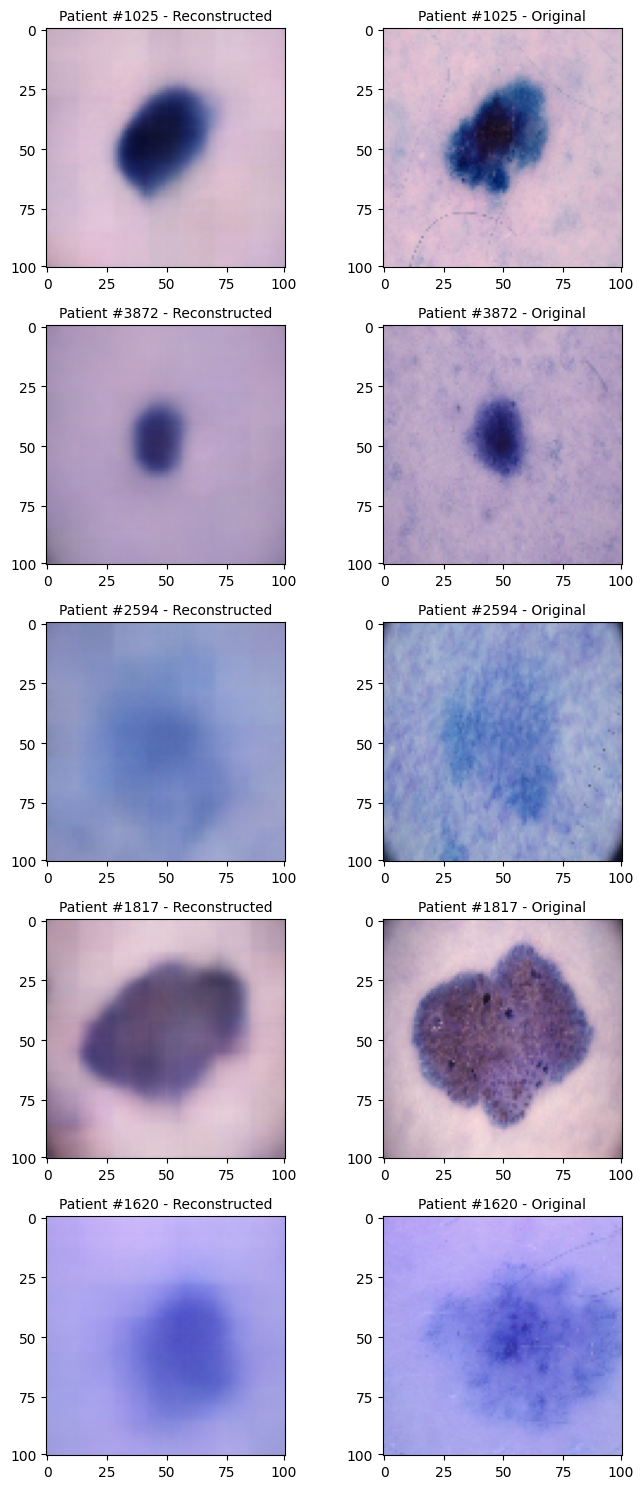

In [9]:
np.random.seed(42)
sample_indices = np.random.choice(len(test_spec_img), size=5, replace=False)

fig, axes = plt.subplots(5, 2, figsize=(7, 15))

for row_idx, test_idx in enumerate(sample_indices):
    reconstructed = reconstructed_images[test_idx]
    original = X_test_normalized[test_idx]
    
    # Reconstructed
    axes[row_idx, 0].imshow(np.clip(reconstructed, 0, 1))
    axes[row_idx, 0].set_title(f'Patient #{test_idx} - Reconstructed', fontsize=10, fontweight='normal')
    tick_vals = [0, 25, 50, 75, 100]
    tick_pos_x = [0, reconstructed.shape[1]*0.25, reconstructed.shape[1]*0.5, reconstructed.shape[1]*0.75, reconstructed.shape[1]-1]
    tick_pos_y = [0, reconstructed.shape[0]*0.25, reconstructed.shape[0]*0.5, reconstructed.shape[0]*0.75, reconstructed.shape[0]-1]
    axes[row_idx, 0].set_xticks(tick_pos_x)
    axes[row_idx, 0].set_yticks(tick_pos_y)
    axes[row_idx, 0].set_xticklabels([str(v) for v in tick_vals])
    axes[row_idx, 0].set_yticklabels([str(v) for v in tick_vals])
    
    # Original
    axes[row_idx, 1].imshow(np.clip(original, 0, 1))
    axes[row_idx, 1].set_title(f'Patient #{test_idx} - Original', fontsize=10, fontweight='normal')
    tick_pos_x = [0, original.shape[1]*0.25, original.shape[1]*0.5, original.shape[1]*0.75, original.shape[1]-1]
    tick_pos_y = [0, original.shape[0]*0.25, original.shape[0]*0.5, original.shape[0]*0.75, original.shape[0]-1]
    axes[row_idx, 1].set_xticks(tick_pos_x)
    axes[row_idx, 1].set_yticks(tick_pos_y)
    axes[row_idx, 1].set_xticklabels([str(v) for v in tick_vals])
    axes[row_idx, 1].set_yticklabels([str(v) for v in tick_vals])

plt.tight_layout()
plt.show()

In [10]:
mse_scores = np.mean((reconstructed_images - X_test_normalized) ** 2, axis=(1, 2, 3))
mae_scores = np.mean(np.abs(reconstructed_images - X_test_normalized), axis=(1, 2, 3))

ssim_scores = []
for i in range(len(reconstructed_images)):
    orig_flat = X_test_normalized[i].flatten()
    recon_flat = reconstructed_images[i].flatten()
    correlation = np.corrcoef(orig_flat, recon_flat)[0, 1]
    ssim_scores.append(correlation)
ssim_scores = np.array(ssim_scores)

avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)
avg_ssim = np.mean(ssim_scores)
metrics_data = [
    {"Metric": "Mean Squared Error (MSE)", "Value": f"{avg_mse:.6f}"},
    {"Metric": "Mean Absolute Error (MAE)", "Value": f"{avg_mae:.6f}"},
    {"Metric": "Pixel Correlation (SSIM proxy)", "Value": f"{avg_ssim:.6f}"},
    {"Metric": "Samples Evaluated", "Value": f"{len(test_spec_img)}"},
]
df_metrics = pd.DataFrame(metrics_data)

if avg_ssim > 0.7:
    risk = "CRITICAL: High-quality reconstruction (>0.7 correlation)"
elif avg_ssim > 0.5:
    risk = "MODERATE: Recognizable reconstructions (0.5-0.7 correlation)"
else:
    risk = "LOW: Poor reconstruction quality (<0.5 correlation)"

df_metrics = pd.concat([df_metrics, pd.DataFrame([{"Metric": "Privacy Risk", "Value": risk}])], ignore_index=True)

html_metrics = df_metrics.to_html(index=False, classes='table table-striped table-bordered', table_id='recon_summary')
display(HTML("<h3>Data Reconstruction Attack - Results Summary</h3>" + html_metrics))

Metric,Value
Mean Squared Error (MSE),0.005324
Mean Absolute Error (MAE),0.049036
Pixel Correlation (SSIM proxy),0.868056
Samples Evaluated,5313
Privacy Risk,CRITICAL: High-quality reconstruction (>0.7 correlation)


In [11]:
ATTRIBUTE_EPOCHS = 20
ATTRIBUTE_BATCH_SIZE = 32
ATTRIBUTE_LEARNING_RATE = 0.001

In [12]:
X_train_attack = train_spec_tab
X_test_attack = test_spec_tab

train_age_true = (train_tabular_features[:, 0] * 15) + 50
test_age_true = (test_tabular_features[:, 0] * 15) + 50

train_sex_true = (train_tabular_features[:, 1] > 0).astype(int)
test_sex_true = (test_tabular_features[:, 1] > 0).astype(int)

def get_age_category(age_array):
    cats = np.zeros(len(age_array), dtype=int)
    cats[age_array < 30] = 0
    cats[(age_array >= 30) & (age_array <= 60)] = 1
    cats[age_array > 60] = 2
    return cats

train_age_cat = get_age_category(train_age_true)
test_age_cat = get_age_category(test_age_true)

train_age_category = train_age_cat
test_age_category = test_age_cat
train_sex_binary = train_sex_true
test_sex_binary = test_sex_true

attack_input_data = pd.DataFrame([{
    'Dataset': 'Training',
    'Embedding Shape': str(X_train_attack.shape),
    'Samples': len(X_train_attack)
}, {
    'Dataset': 'Test',
    'Embedding Shape': str(X_test_attack.shape),
    'Samples': len(X_test_attack)
}])

ground_truth_data = pd.DataFrame([{
    'Dataset': 'Training',
    'Samples': len(train_age_true),
    'Age Range': f"{train_age_true.min():.1f} - {train_age_true.max():.1f}",
    'Sex Balance': f"{np.mean(train_sex_true)*100:.1f}% Male"
}, {
    'Dataset': 'Test',
    'Samples': len(test_age_true),
    'Age Range': f"{test_age_true.min():.1f} - {test_age_true.max():.1f}",
    'Sex Balance': f"{np.mean(test_sex_true)*100:.1f}% Male"
}])

display(HTML("<h4>Attacker Input (Leaked Embeddings)</h4>"))
display(attack_input_data)

display(HTML("<h4>Ground Truth Attributes (Restored from Normalized Features)</h4>"))
display(ground_truth_data)

,Dataset,Embedding Shape,Samples
0,Training,"(21252, 64)",21252
1,Test,"(5313, 64)",5313


,Dataset,Samples,Age Range,Sex Balance
0,Training,21252,0.5 - 74.0,54.1% Male
1,Test,5313,0.5 - 74.0,54.8% Male


In [13]:
attribute_input = Input(shape=(train_spec_tab.shape[1],), name='tabular_embedding_input')

x = Dense(256, activation='relu', name='shared_dense1')(attribute_input)
x = Dropout(0.3, name='shared_dropout1')(x)
x = Dense(128, activation='relu', name='shared_dense2')(x)
x = Dropout(0.2, name='shared_dropout2')(x)

age_branch = Dense(64, activation='relu', name='age_dense')(x)
age_output = Dense(3, activation='softmax', name='age_output')(age_branch)

sex_branch = Dense(64, activation='relu', name='sex_dense')(x)
sex_output = Dense(1, activation='sigmoid', name='sex_output')(sex_branch)
attribute_decoder = Model(
    inputs=attribute_input,
    outputs=[age_output, sex_output],
    name='AttributeDecoder'
)

# Compile with combined loss
attribute_decoder.compile(
    optimizer=Adam(learning_rate=ATTRIBUTE_LEARNING_RATE),
    loss={
        'age_output': 'sparse_categorical_crossentropy',
        'sex_output': 'binary_crossentropy'
    },
    loss_weights={
        'age_output': 1.0,
        'sex_output': 1.0
    },
    metrics={
        'age_output': 'accuracy',
        'sex_output': 'accuracy'
    }
)

summary_data = []
for layer in attribute_decoder.layers:
    layer_type = layer.__class__.__name__
    
    if hasattr(layer, 'output_shape') and layer.output_shape is not None:
        if isinstance(layer.output_shape, tuple):
            shape_str = str(layer.output_shape)
        else:
            shape_str = str(layer.output_shape)
    elif hasattr(layer, 'output') and layer.output is not None:
        try:
            shape_str = str(layer.output.shape)
        except:
            shape_str = 'N/A'
    else:
        shape_str = 'N/A'
    
    params = layer.count_params() if hasattr(layer, 'count_params') else 0
    
    summary_data.append({
        'Layer': layer.name,
        'Type': layer_type,
        'Output Shape': shape_str,
        'Params': f'{params:,}'
    })

df_summary = pd.DataFrame(summary_data)
df_summary['Trainable'] = ['Yes' if layer.trainable else 'No' for layer in attribute_decoder.layers]

total_params = sum([layer.count_params() for layer in attribute_decoder.layers if hasattr(layer, 'count_params')])
trainable_params = sum([layer.count_params() for layer in attribute_decoder.layers if hasattr(layer, 'count_params') and layer.trainable])
non_trainable_params = total_params - trainable_params
html_table = df_summary.to_html(index=False, classes='table table-striped table-bordered', 
                                table_id='attribute_decoder_summary', escape=False)
html_table += f'<br><b>Total params:</b> {total_params:,}<br>'
html_table += f'<b>Trainable params:</b> {trainable_params:,}<br>'
html_table += f'<b>Non-trainable params:</b> {non_trainable_params:,}<br>'

display(HTML(html_table))

Layer,Type,Output Shape,Params,Trainable
tabular_embedding_input,InputLayer,"(None, 64)",0,Yes
shared_dense1,Dense,"(None, 256)","16,640",Yes
shared_dropout1,Dropout,"(None, 256)",0,Yes
shared_dense2,Dense,"(None, 128)","32,896",Yes
shared_dropout2,Dropout,"(None, 128)",0,Yes
age_dense,Dense,"(None, 64)","8,256",Yes
sex_dense,Dense,"(None, 64)","8,256",Yes
age_output,Dense,"(None, 3)",195,Yes
sex_output,Dense,"(None, 1)",65,Yes


In [14]:
attribute_history = attribute_decoder.fit(
    train_spec_tab,
    {'age_output': train_age_category, 'sex_output': train_sex_binary},
    validation_split=0.1,
    epochs=ATTRIBUTE_EPOCHS,
    batch_size=ATTRIBUTE_BATCH_SIZE,
    verbose=1
)

test_results = attribute_decoder.evaluate(
    test_spec_tab,
    {'age_output': test_age_category, 'sex_output': test_sex_binary},
    verbose=0
)

Epoch 1/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - age_output_accuracy: 0.7872 - age_output_loss: 0.5074 - loss: 0.6275 - sex_output_accuracy: 0.9687 - sex_output_loss: 0.1201 - val_age_output_accuracy: 0.9591 - val_age_output_loss: 0.1011 - val_loss: 0.1020 - val_sex_output_accuracy: 1.0000 - val_sex_output_loss: 3.5067e-04
Epoch 2/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - age_output_accuracy: 0.9588 - age_output_loss: 0.1144 - loss: 0.1160 - sex_output_accuracy: 0.9996 - sex_output_loss: 0.0016 - val_age_output_accuracy: 0.9948 - val_age_output_loss: 0.0345 - val_loss: 0.0348 - val_sex_output_accuracy: 1.0000 - val_sex_output_loss: 8.9220e-05
Epoch 3/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - age_output_accuracy: 0.9793 - age_output_loss: 0.0575 - loss: 0.0590 - sex_output_accuracy: 0.9998 - sex_output_loss: 0.0014 - val_age_output_accuracy: 0.9953 - val_age_output_loss: 0.0193 - val_loss: 0.0195 - val_sex_output_accuracy: 1.0000 - val_sex_output_loss: 2.7336e-05
Epoch 4/20

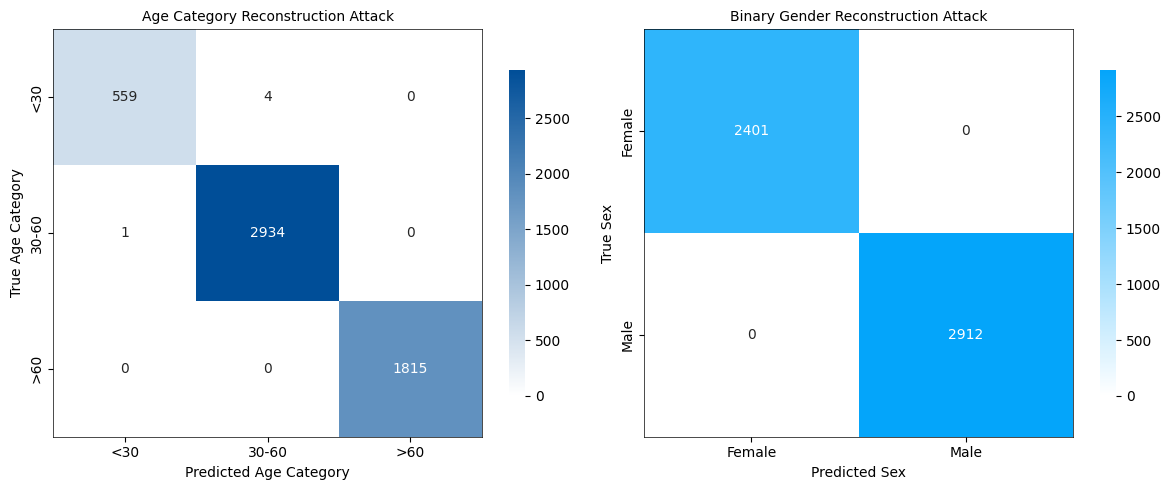

,Metric,Test Performance,Inference Accuracy,Baseline (Random),Improvement
0,Age Category Accuracy,0.9991 (99.91%),0.9991 (99.91%),0.5524 (55.24%),44.66%
1,Sex Accuracy,1.0000 (100.00%),1.0000 (100.00%),0.5481 (54.81%),45.19%


In [15]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
from IPython.display import HTML, display

age_colors = ['#FFFFFF', '#004E98']  # white to dark blue
sex_colors = ['#FFFFFF', '#04A5FA']  # white to light blue
age_cmap = LinearSegmentedColormap.from_list('age_cmap', age_colors, N=256)
sex_cmap = LinearSegmentedColormap.from_list('sex_cmap', sex_colors, N=256)

if 'test_age_category' not in locals():
    test_age_category = test_age_cat
if 'test_sex_binary' not in locals():
    test_sex_binary = test_sex_true

age_pred_probs, sex_pred_probs = attribute_decoder.predict(test_spec_tab, verbose=0)
age_pred_category = np.argmax(age_pred_probs, axis=1)
sex_pred_binary = (sex_pred_probs.flatten() > 0.5).astype(int)

age_accuracy = np.mean(age_pred_category == test_age_category)
sex_accuracy = np.mean(sex_pred_binary == test_sex_binary)

age_class_counts = np.bincount(test_age_category)
age_baseline = np.max(age_class_counts) / len(test_age_category)
sex_class_counts = np.bincount(test_sex_binary)
sex_baseline = np.max(sex_class_counts) / len(test_sex_binary)

fig = plt.figure(figsize=(12, 5))

ax1 = plt.subplot(1, 2, 1)

age_cm = confusion_matrix(test_age_category, age_pred_category)
sns.heatmap(age_cm, annot=True, fmt='d', cmap=age_cmap, ax=ax1, 
            xticklabels=['<30', '30-60', '>60'],
            yticklabels=['<30', '30-60', '>60'],
            linewidths=0, cbar_kws={'shrink': 0.8})

for spine in ax1.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('black')
    spine.set_linewidth(0.5)

ax1.set_xlabel('Predicted Age Category', fontsize=10, fontweight='normal')
ax1.set_ylabel('True Age Category', fontsize=10, fontweight='normal')
ax1.set_title('Age Category Reconstruction Attack', 
              fontsize=10, fontweight='normal')

ax2 = plt.subplot(1, 2, 2)

sex_cm = confusion_matrix(test_sex_binary, sex_pred_binary)
sns.heatmap(sex_cm, annot=True, fmt='d', cmap=sex_cmap, ax=ax2, 
            xticklabels=['Female', 'Male'],
            yticklabels=['Female', 'Male'],
            linewidths=0, cbar_kws={'shrink': 0.8})

for spine in ax2.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('black')
    spine.set_linewidth(0.5)

ax2.set_xlabel('Predicted Sex', fontsize=10, fontweight='normal')
ax2.set_ylabel('True Sex', fontsize=10, fontweight='normal')
ax2.set_title('Binary Gender Reconstruction Attack', 
              fontsize=10, fontweight='normal')


plt.tight_layout()
plt.show()


results_data = pd.DataFrame([
    {
        'Metric': 'Age Category Accuracy',
        'Test Performance': f"{test_results[3]:.4f} ({test_results[3]*100:.2f}%)",
        'Inference Accuracy': f"{age_accuracy:.4f} ({age_accuracy*100:.2f}%)",
        'Baseline (Random)': f"{age_baseline:.4f} ({age_baseline*100:.2f}%)",
        'Improvement': f"{(age_accuracy - age_baseline)*100:.2f}%"
    },
    {
        'Metric': 'Sex Accuracy',
        'Test Performance': f"{test_results[4]:.4f} ({test_results[4]*100:.2f}%)",
        'Inference Accuracy': f"{sex_accuracy:.4f} ({sex_accuracy*100:.2f}%)",
        'Baseline (Random)': f"{sex_baseline:.4f} ({sex_baseline*100:.2f}%)",
        'Improvement': f"{(sex_accuracy - sex_baseline)*100:.2f}%"
    }
])

display(HTML("<h3>Attribute Inference Attack Results Summary</h3>"))
display(results_data)